# AIPI 590 - XAI | Assignment #2
### Interpretable ML
### Kayla Haeussler

#### Include the button below. Change the link to the location in your github repository:
#### Example: https://github.com/khaeuss808/AIPI590_InterpretableAI/blob/main/Assignment1.ipynb


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khaeuss808/AIPI590_InterpretableAI/blob/main/Assignment1.ipynb)

In [179]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI590_InterpretableAI" # Change to your repo name
git_path = 'https://github.com/khaeuss808/AIPI590_InterpretableAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = ''
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: ./sample_data: No such file or directory
Cloning into 'AIPI590_InterpretableAI'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 26 (delta 11), reused 21 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 387.75 KiB | 3.80 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/Users/kaylahaeusssler/Documents/XAI/AIPI590_InterpretableAI/AIPI590_InterpretableAI
Assignment1.ipynb                     WA_Fn-UseC_-Telco-Customer-Churn.csv
README.md


In [25]:
from google.colab import userdata

userdata.get("secretName")

ModuleNotFoundError: No module named 'google'

In [163]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    log_loss,
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from pygam import LogisticGAM

In [133]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# (1) Exploratory Data Analysis

> Will begin by encoding Churn as 0 and 1, as opposed to current state of Yes and No

In [134]:
print(df.shape)

# Y var
df["Churn"] = [1 if x == "Yes" else 0 for x in df["Churn"]]

(7043, 21)


In [135]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

> TotalCharges is of type object, but should be numeric. Converting below and also removing the 11 rows that resulted in NaNs

In [136]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df[df["TotalCharges"].isna()]
df = df.dropna(subset=["TotalCharges"])

> Encoding categorical variables as is necessary for our future models

In [137]:
# customerID does not contribute value to the model as it is just a unique
#       identifier for customers, so I am dropping that col
df = df.drop(columns=["customerID"])
df_log = df.copy()  # for use in question 3, logistic regression
df_encoded = pd.get_dummies(df, drop_first=True, dtype=float)
print(df_encoded.shape)

(7032, 31)


> Splitting our data into features and output variable, and then splitting into training and test set for use in the following models

In [138]:
X = df_encoded.drop(columns=["Churn"])
y = df_encoded["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

> In the assingment description, this question also asks us to check that assumptions are met for each of the following models. Since assessing the assumptions in most cases requires first fitting the model, I check assumptions after fitting the models in each of the corresponding sections

# (2) Linear Regression

Linear Regression holds the following assumptions (as listed in class slides)
* Linearity
* Independence
* Homoscedasticity
* Normality of Residuals
* No Multicolinearity
* No Autocorrelation

After fitting my Linear Regression model below, I then evaluate if these assumptions are uphelp. I list the name of the assumption and then the corresponding plot/test in an md box.

> Below are evaluate model and residual plotting functions contained in Dr. Bent's notebook regression-interpretability.ipynb on the course GitHub

In [139]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    for feature, coef in zip(X.columns, model.coef_):
        print(f"{feature}: {coef:.4f}")

    return model, y_pred

> I fit and evulate the Linear Regression model below, using the evaluate_model function defined above

In [140]:
lr_model, lr_pred = evaluate_model(
    LinearRegression(), X_train, X_test, y_train, y_test, "Linear Regression"
)


Linear Regression:
MSE: 0.15
R2 Score: 0.25
SeniorCitizen: 0.0546
tenure: -0.0019
MonthlyCharges: -0.0037
TotalCharges: -0.0000
gender_Male: -0.0037
Partner_Yes: 0.0070
Dependents_Yes: -0.0284
PhoneService_Yes: 0.0214
MultipleLines_No phone service: -0.0214
MultipleLines_Yes: 0.0685
InternetService_Fiber optic: 0.2735
InternetService_No: -0.0333
OnlineSecurity_No internet service: -0.0333
OnlineSecurity_Yes: -0.0372
OnlineBackup_No internet service: -0.0333
OnlineBackup_Yes: 0.0076
DeviceProtection_No internet service: -0.0333
DeviceProtection_Yes: 0.0215
TechSupport_No internet service: -0.0333
TechSupport_Yes: -0.0380
StreamingTV_No internet service: -0.0333
StreamingTV_Yes: 0.0921
StreamingMovies_No internet service: -0.0333
StreamingMovies_Yes: 0.0953
Contract_One year: -0.1167
Contract_Two year: -0.0746
PaperlessBilling_Yes: 0.0359
PaymentMethod_Credit card (automatic): -0.0095
PaymentMethod_Electronic check: 0.0623
PaymentMethod_Mailed check: -0.0064


> R-squared is pretty low, only 25% of the variation in Churn is explained by this model. Linear regression is difficult to interpret in a classification setting like this (Churn/no Churn). Typically, we interpret coefficients in linear regression by how they increase/decrease the continuous outcome variable, but because the outcome variable is not continouos in this case, Linear regression is not a great choice (as we see when assumptions are assessed below) and it is difficult to interpret the coefficients

### Linearity & Homoscedasticity: Residuals vs Fitted Plot

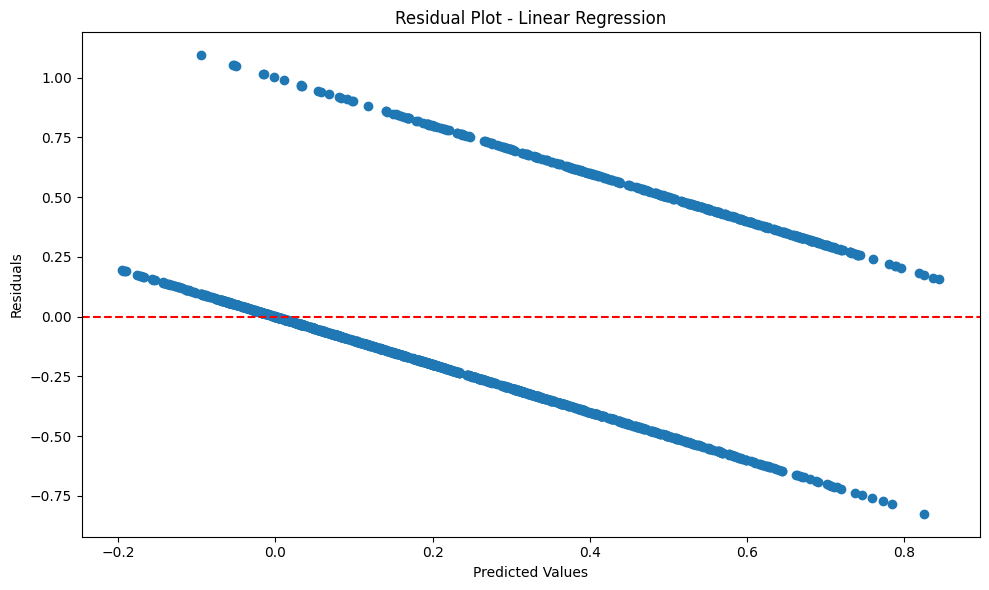

In [141]:
# Residual Plot: from Dr. Bent's notebook
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {model_name}")
    plt.axhline(y=0, color="r", linestyle="--")
    plt.tight_layout()
    plt.show()


plot_residuals(y_test, lr_pred, "Linear Regression")

> The above plot shows two strong lines, not a random cloud pattern, which tells us the linearity assumption is violated. The two strong lines also have variance that changes with the fitted values (diagonalness) which tells us that homoscedasticity is violated

### Normality of Residuals: QQ Plot

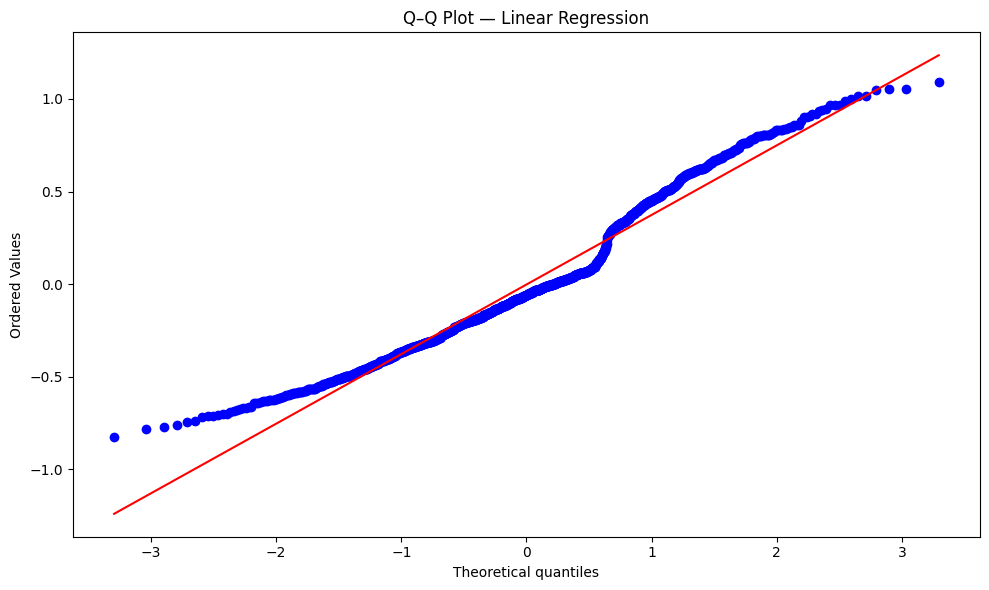

In [142]:
residuals = y_test - lr_pred
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title(f"Q–Q Plot — Linear Regression")
plt.tight_layout()
plt.show()

> The above plot shows variation from the diagonal (S shape) which tells us residuals are not normal and this assumption is violated.

### Multicollinearity: VIF

In [143]:
# ChatGPT was used to generate this block of code
Xv = sm.add_constant(X_train, has_constant="add")  # add intercept

vif = pd.DataFrame(
    {
        "feature": Xv.columns[1:],  # skip intercept
        "VIF": [variance_inflation_factor(Xv.values, i) for i in range(1, Xv.shape[1])],
    }
).sort_values("VIF", ascending=False)

# print(vif)
print("\nVIF > 5:\n", vif[vif["VIF"] > 5])

/Users/kaylahaeusssler/miniforge3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF > 5:
                                  feature         VIF
11                    InternetService_No         inf
12    OnlineSecurity_No internet service         inf
20       StreamingTV_No internet service         inf
18       TechSupport_No internet service         inf
16  DeviceProtection_No internet service         inf
7                       PhoneService_Yes         inf
8         MultipleLines_No phone service         inf
14      OnlineBackup_No internet service         inf
22   StreamingMovies_No internet service         inf
2                         MonthlyCharges  875.944051
10           InternetService_Fiber optic  149.302028
23                   StreamingMovies_Yes   24.332467
21                       StreamingTV_Yes   24.176885
3                           TotalCharges   10.667213
1                                 tenure    7.475610
9                      MultipleLines_Yes    7.316372
17                  DeviceProtection_Yes    6.896485
15                      OnlineBacku

> The VIF results show pretty severe multicollinearity (VIF>5)

### Autocorrelation: Durbin Watson Test

In [144]:
# ChatGPT was used to generate this block of code
resid_train = y_train - lr_model.predict(X_train)
dw = durbin_watson(resid_train)

print(f"Durbin–Watson: {dw:.3f}")

Durbin–Watson: 1.997


> The result of the DW test being around 2 tells us that there is no autocorrelation and that this assumption is upheld

Our linear regression model failed many of the assumptions of an LR model. This result is not surprising to me as linear regression is best used to predict a continuous outcome, and in this case we were using it to predict a binary outcome.

# (3) Logistic Regression
Logistic Regression holds the following assumptions (as listed in class slides)
* Linearity
* No Multicolinearity
* Independence of observations
* No influential outliers
* Absence of perfect separation
* Large Sample Size

After fitting my Logistic Regression model below, I then evaluate if these assumptions are uphelp. I list the name of the assumption and then the corresponding plot/test in an md box.
Pivoting away from using sklearn's functionality as Dr. Bent had in the functions of her's I was using for linear regression as I was encountering friction, switching to stat models as I am a little more comfortable

In [145]:
# documentation says that with statmodels one must manually add a constant, so doing that here
X_train_c = sm.add_constant(X_train, has_constant="add")
X_test_c = sm.add_constant(X_test, has_constant="add")

# logit_res = sm.Logit(y_train, X_train_c).fit()

> When I originally tried to fit my model above I was getting an error saying my design matrix had perfect collinearity. After some digging, I believe this is because there are multiple columns with the level no internet service which are equal to the InternetService and PhoneService column (issue is also seen in VIF of linear regression). In order to continue with the logistic regression, I am converting these levels in the columns of concern to also be "No"

In [162]:
# columns with the "no internet service" level
svc_cols = [
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]
# changing to no
df_log[svc_cols] = df_log[svc_cols].replace({"No internet service": "No"})
df_log["MultipleLines"] = df_log["MultipleLines"].replace({"No phone service": "No"})

# re encoding now that that issue is hopefully fixed
df_encoded = pd.get_dummies(df_log, drop_first=True, dtype=float)

# replitting X and y
X = df_encoded.drop(columns=["Churn"])
y = df_encoded["Churn"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# adding the contstants again
X_train_c = sm.add_constant(X_train, has_constant="add")
X_test_c = sm.add_constant(X_test, has_constant="add")
logit_res = sm.Logit(y_train, X_train_c).fit()

logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.410277
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 5625
Model:                          Logit   Df Residuals:                     5601
Method:                           MLE   Df Model:                           23
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                  0.2914
Time:                        00:17:09   Log-Likelihood:                -2307.8
converged:                       True   LL-Null:                       -3257.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     1.7158      0.924      1.858      0.063      -0.094       3.526
SeniorCitizen                             0.2597      0.095      2.726      0.006       0.073       0.447
tenure                                   -0.0616      0.007     -8.735      0.000      -0.075      -0.048
MonthlyCharges                           -0.0608      0.036     -1.691      0.091      -0.131       0.010
TotalCharges                              0.0003   7.97e-05      4.221      0.000       0.000       0.000
gender_Male                              -0.0302      0.073     -0.414      0.679      -0.173       0.113
Partner_Yes                               0.0504      0.088      0.574      0.566      -0.122       0.222
Dependents_Yes                           -0.2155      0.102     -2.121      0.034      -0.415      -0.016
PhoneService_Yes                          0.5807      0.734      0.791      0.429      -0.857       2.019
MultipleLines_Yes                         0.5235      0.201      2.606      0.009       0.130       0.917
InternetService_Fiber optic               2.2956      0.904      2.541      0.011       0.525       4.067
InternetService_No                       -2.2454      0.913     -2.460      0.014      -4.034      -0.457
OnlineSecurity_Yes                       -0.1484      0.202     -0.735      0.462      -0.544       0.247
OnlineBackup_Yes                          0.1759      0.198      0.887      0.375      -0.213       0.565
DeviceProtection_Yes                      0.2782      0.198      1.402      0.161      -0.111       0.667
TechSupport_Yes                          -0.1194      0.204     -0.585      0.559      -0.520       0.281
StreamingTV_Yes                           0.8290      0.369      2.247      0.025       0.106       1.552
StreamingMovies_Yes                       0.8488      0.370      2.294      0.022       0.123       1.574
Contract_One year                        -0.7698      0.123     -6.268      0.000      -1.010      -0.529
Contract_Two year                        -1.3444      0.196     -6.864      0.000      -1.728      -0.961
PaperlessBilling_Yes                      0.2724      0.083      3.267      0.001       0.109       0.436
PaymentMethod_Credit card (automatic)    -0.1410      0.129     -1.095      0.274      -0.393       0.111
PaymentMethod_Electronic check            0.2600      0.106      2.444      0.015       0.051       0.469
PaymentMethod_Mailed check               -0.0714      0.128     -0.557      0.578      -0.323       0.180
=========================================================================================================
"""

> Logistic regression is much better suited to binary classification than linear regression, so interpreting the coefficients is possible here. There are many significant features (pvalue >0.05), we can interpret these as those who effect the odds with significance, from their reference level in the case of categorical variables. Each coefficient represents a change in log-odds. We can interpret the significant coefficients as follows:  
* SeniorCitizen: seniors have about 30% higher odds of churn than non-seniors (odds ratio ≈ 1.30).
* tenure: each +1 month reduces churn odds by ~6% (odds ratio ≈ 0.94); roughly 52% lower per year (odds ratio ≈ 0.48).
* TotalCharges: about 3% higher churn odds per $100 increase (odds ratio ≈ 1.03; note overlap with tenure/MonthlyCharges).
* Dependents_Yes: customers with dependents have ~19% lower odds (odds ratio ≈ 0.81).
* MultipleLines_Yes: having multiple lines is linked to ~69% higher odds (odds ratio ≈ 1.69).
* InternetService_Fiber optic: ~10× higher odds vs DSL (odds ratio ≈ 9.9).
* InternetService_No: ~89% lower odds vs DSL (odds ratio ≈ 0.11).
* StreamingTV_Yes: ~129% higher odds (odds ratio ≈ 2.29).
* StreamingMovies_Yes: ~134% higher odds (odds ratio ≈ 2.34).
* Contract_One year: ~54% lower odds vs month-to-month (odds ratio ≈ 0.46).
* Contract_Two year: ~74% lower odds vs month-to-month (odds ratio ≈ 0.26).
* PaperlessBilling_Yes: ~31% higher odds (odds ratio ≈ 1.31).
* PaymentMethod_Electronic check: ~30% higher odds vs bank transfer (auto) (odds ratio ≈ 1.30).

### Linearity: Box-Tidwell

In [149]:
# a Google search suggested using Box-Tidwell to test linearity for Logit
cont_cols = [c for c in X_train.columns if X_train[c].nunique() > 5]
bt_rows = []
for col in cont_cols:
    x = X_train[col].astype(float)
    x_pos = x - x.min() + 1e-6  # shift so log() is defined
    X_bt = X_train.copy()
    X_bt[f"{col}_xlogx"] = x_pos * np.log(x_pos)
    X_bt_c = sm.add_constant(X_bt, has_constant="add")
    res_bt = sm.Logit(y_train, X_bt_c).fit(disp=0)
    p = res_bt.pvalues.get(f"{col}_xlogx", np.nan)
    bt_rows.append((col, p))

bt_df = pd.DataFrame(bt_rows, columns=["variable", "p_xlogx"]).sort_values("p_xlogx")
print("\nLinearity check (Box–Tidwell p-values; p<0.05 => nonlinearity):")
print(bt_df)


Linearity check (Box–Tidwell p-values; p<0.05 => nonlinearity):
         variable       p_xlogx
0          tenure  2.705971e-15
2    TotalCharges  1.207470e-08
1  MonthlyCharges  5.431861e-01


> Tenure and totalCharges both violate linearity. MonthlyCharges is okay

### Multicolinearity: VIF

In [177]:
# calculating VIF similar to how we did for linear regression
vif_df = pd.DataFrame(
    {
        "feature": X_train_c.columns[1:],
        "VIF": [
            variance_inflation_factor(X_train_c.values, i)
            for i in range(1, X_train_c.shape[1])
        ],
    }
).sort_values("VIF", ascending=False)


print("\nVIF > 5:")
print(vif_df[vif_df["VIF"] > 5])


VIF > 5:
                        feature         VIF
2                MonthlyCharges  875.944051
9   InternetService_Fiber optic  149.302028
10           InternetService_No  105.613911
7              PhoneService_Yes   35.297238
16          StreamingMovies_Yes   24.332467
15              StreamingTV_Yes   24.176885
3                  TotalCharges   10.667213
1                        tenure    7.475610
8             MultipleLines_Yes    7.316372
13         DeviceProtection_Yes    6.896485
12             OnlineBackup_Yes    6.876888
14              TechSupport_Yes    6.508620
11           OnlineSecurity_Yes    6.382090


> The VIF shows serious multicollinearity, though the infinity values shown in the linear regression's VIF has been resolved after I pinpointed the columns with perfect collinearity. 

### Independence: Durbin Watson

In [155]:
p_train = logit_res.predict(X_train_c)
resid_response = y_train - p_train
print("Durbin–Watson:", f"{durbin_watson(resid_response):.3f}")

Durbin–Watson: 1.995


> This value is close to 2, which indicates no evidence of first-order autocorrelation, the independence assumptions seems fulfilled

### Influential Outliers: Cook's Distance

In [159]:
infl = logit_res.get_influence()
inf = infl.summary_frame()  # includes 'hat_diag', 'cooks_d', 'standard_resid' for Logit

n = len(y_train)
p = X_train_c.shape[1]  # includes intercept
cook_thr = 4 / n
lev_thr = 2 * p / n

print("\nPotentially influential (Cook's D > 4/n):")
print(inf[inf["cooks_d"] > cook_thr].sort_values("cooks_d", ascending=False).head(10))

print("\nHigh leverage (hat_diag > 2p/n):")
print(inf[inf["hat_diag"] > lev_thr].sort_values("hat_diag", ascending=False).head(10))

print("\nLarge residuals (|standard_resid| > 3):")
print(
    inf[inf["standard_resid"].abs() > 3]
    .sort_values("standard_resid", key=np.abs, ascending=False)
    .head(10)
)


Potentially influential (Cook's D > 4/n):
      dfb_const  dfb_SeniorCitizen  dfb_tenure  dfb_MonthlyCharges  \
268   -0.024565          -0.000963    0.284109           -0.003224   
4272  -0.049157          -0.020343    0.225220            0.024106   
430   -0.031127          -0.009368    0.289276            0.000007   
4819  -0.018826           0.018796    0.226179            0.006281   
6792  -0.027522          -0.015823    0.234708            0.006963   
4149   0.004827          -0.029808    0.172365           -0.007973   
6813   0.058428          -0.021607    0.148689           -0.059978   
6424   0.004884          -0.033494    0.151676           -0.009143   
6724  -0.032421           0.090176    0.087878            0.019232   
4386   0.068906           0.011811    0.105191           -0.076394   

      dfb_TotalCharges  dfb_gender_Male  dfb_Partner_Yes  dfb_Dependents_Yes  \
268          -0.268957         0.031430        -0.037621           -0.033410   
4272         -0.232847    

In [178]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
sizes = 2000 * np.minimum(out["cookD"], cook_thr * 5)  # cap size for readability
plt.scatter(out["leverage"], out["|std_resid|"] ** 2, s=sizes, alpha=0.3)

# thresholds
plt.axvline(lev_thr, ls="--", label=f"leverage = 2p/n ({lev_thr:.3f})")
plt.axhline(3**2, ls="--", label="(std resid)^2 = 9")
plt.title("Influence plot: leverage vs residual^2 (size = Cook's D)")
plt.xlabel("Leverage (hat_diag)")
plt.ylabel("Standardized residual squared")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'out' is not defined

<Figure size 700x500 with 0 Axes>

# (4) Generalized Additive Model

In [166]:
# this was my first time using a GAM, so talked with chatGPT about the different types of GAMs
# it recommended logisticGAM since we have a binary Y
gam = LogisticGAM().gridsearch(X_train.values, y_train.values)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:32
 18% (2 of 11) |####                     | Elapsed Time: 0:00:05 ETA:   0:00:23
 27% (3 of 11) |######                   | Elapsed Time: 0:00:06 ETA:   0:00:16
 36% (4 of 11) |#########                | Elapsed Time: 0:00:09 ETA:   0:00:16
 45% (5 of 11) |###########              | Elapsed Time: 0:00:10 ETA:   0:00:12
 54% (6 of 11) |#############            | Elapsed Time: 0:00:11 ETA:   0:00:09
 63% (7 of 11) |###############          | Elapsed Time: 0:00:12 ETA:   0:00:07
 72% (8 of 11) |##################       | Elapsed Time: 0:00:13 ETA:   0:00:05
 81% (9 of 11) |####################     | Elapsed Time: 0:00:15 ETA:   0:00:03
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:16 ETA:   0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


In [172]:
# Referenced Dr. Bent's generalized-models-interpretability.ipynb notebook
# Make predictions
y_pred_gam = gam.predict(X_test)

# Calculate MSE and R^2
mse_gam = mean_squared_error(y_test, y_pred_gam)
r2_gam = r2_score(y_test, y_pred_gam)

print(f"GAM MSE: {mse_gam:.4f}, R^2: {r2_gam:.4f}")

gam.summary()

GAM MSE: 0.2075, R^2: -0.0634
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      34.203
Link Function:                        LogitLink Log Likelihood:                                 -2262.2437
Number of Samples:                         5625 AIC:                                             4592.8933
                                                AICc:                                            4593.3494
                                                UBRE:                                               2.8214
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3054
Feature

/var/folders/bs/tlrmg2n164520pry59rs7fvh0000gn/T/ipykernel_62034/2473575865.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


> The GAM explains about 30% of the deviance based on the pseudo-Rsquared of 0.31. Several features exhibit non-linear effects (EDoF > 1), specifically those mapped to s(1), s(2), s(3), s(0). Below we visualize what this actually means in the context of customer churn

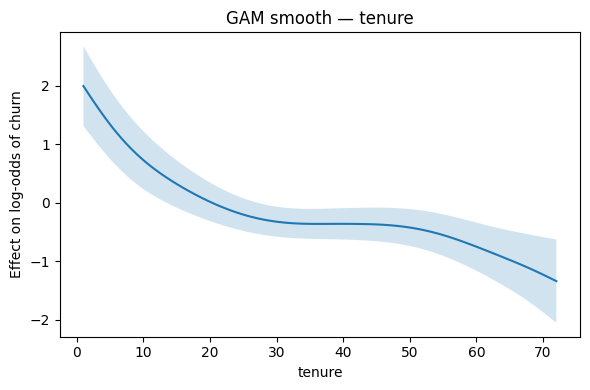

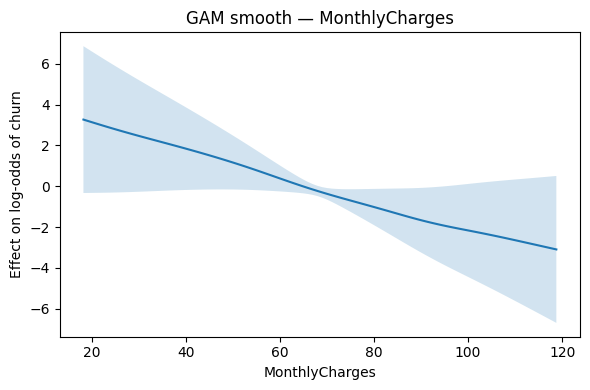

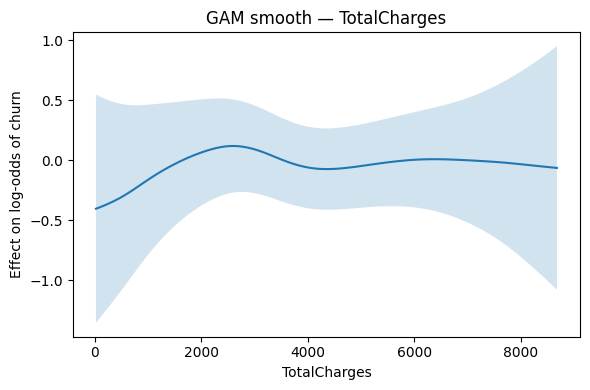

In [176]:
# Asked ChatGPT for assistance in adapting Dr. Bent's plotting code from generalized-models-interpretability.ipynb
#   adapted to our case. Resulting code is below

feature_names = list(X_train.columns)
# treat "continuous" as columns with more than 10 unique values
cont_cols = [c for c in feature_names if X_train[c].nunique() > 10]


def term_index_for_feature(gam, feat_name):
    """Return the term index in gam.terms that corresponds to this feature."""
    feat_idx = feature_names.index(feat_name)
    for j, t in enumerate(gam.terms):
        if getattr(t, "isintercept", False):
            continue
        # s()/l() terms have .feature; tensor terms have .features
        if hasattr(t, "feature") and t.feature == feat_idx:
            return j, feat_idx
        if hasattr(t, "features") and feat_idx in t.features:
            return j, feat_idx
    return None, None  # not found (e.g., feature not modeled)


def plot_smooth(gam, feat):
    j, feat_idx = term_index_for_feature(gam, feat)
    if j is None:
        return
    XX = gam.generate_X_grid(term=j)
    pdp, confi = gam.partial_dependence(term=j, X=XX, width=0.95)
    lo, hi = confi[:, 0], confi[:, 1]
    x = XX[:, feat_idx]

    plt.figure(figsize=(6, 4))
    plt.plot(x, pdp)
    plt.fill_between(x, lo, hi, alpha=0.2)
    plt.xlabel(feat)
    plt.ylabel("Effect on log-odds of churn")
    plt.title(f"GAM smooth — {feat}")
    plt.tight_layout()
    plt.show()


# loop over all continuous features
for feat in cont_cols:
    plot_smooth(gam, feat)

> By looking at the plots, we see the tenure curve drops hard in the first ~20 months and then levels off telling us that earlier customers are much more likely to churn than longer time customers. MonthlyCharges trends downward overall (with wide bands at the very low/high ends), which suggests higher-priced plans churn less once you control for plan/contract mix. TotalCharges are basically flat. 

> GAM Assumptions include: (class slides do not list any assumptions, found these through Google search)
* Right family/link
* Additivity & Smoothness
* Independence of observation

For Right family/link, we used a LogisticGAM which takes binomial + logit, which is appropriate for our binary outcome of Churn.  For Additivity, from the summary of the GAM, the terms with edf>1 show real non-linear signal. For Independence, because each row of our data represents one customer, we can reasonably assume independence. 

# (5) Model Comparison

Linear regression (OLS) — not a good fit for a 0/1 target. The residual plot showed the classic two-band pattern, non-normal residuals, and heteroscedasticity; predictions can fall outside 
0
,
1
0,1. I’d keep OLS only as a teaching baseline—not for reporting or deployment.

Logistic regression — the right baseline. It gives clean odds-ratio interpretations (e.g., longer tenure lowers churn odds; one- and two-year contracts reduce risk; fiber-optic plans raise risk), and after fixing the “No internet service” dummies the model fit well. Your run showed Pseudo-R² ≈ 0.29, independence looked fine (DW ≈ 2), and multicollinearity was manageable. It’s simple to monitor and explain to stakeholders.

GAM (LogisticGAM) — adds flexible, data-driven curves for the continuous features. You picked up meaningful nonlinearity: tenure drops sharply in the first ~20 months then flattens; MonthlyCharges trends down once plan/contract mix is controlled; TotalCharges adds little beyond those. This bought a modest lift in fit (Pseudo-R² ≈ 0.31) at the cost of a bit more complexity.

Recommendation: use logistic regression as the production model (clear, stable, easy to communicate), and use the GAM as a companion analysis to understand non-linear patterns (e.g., early-life churn) and to sanity-check whether simple transforms or interactions should be added to the logistic model. If the business prioritizes raw accuracy over simplicity, you could pilot the GAM for scoring—but for day-to-day churn management, logistic is the best balance of performance and interpretability.